# Tarea 3 - Logistic Regression, classification, Metropolis-Hastings and Monte Carlo

In [1]:
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal, uniform

### Data generation

First we need to generate the data. We will use the make moons dataset creation tool from sklearn to create our dataset.

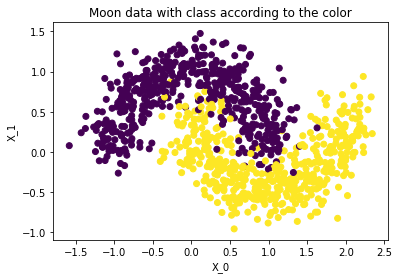

In [2]:
# generate data
noise = 0.2
n_samples = 1000
percent_test = 0.2
X, y = sklearn.datasets.make_moons(n_samples=n_samples, shuffle=True, noise=noise)
# X, y = sklearn.datasets.make_blobs(n_samples=n_samples, shuffle=True, centers=2, cluster_std=7)

# divide test and train dataset
idx_sep = int(n_samples*percent_test)
X_train, y_train = X[idx_sep:,:], y[idx_sep:]
X_test, y_test = X[:idx_sep,:], y[:idx_sep]

# visualize data
plt.scatter(X[:,0], X[:,1], c=y)
plt.title("Moon data with class according to the color")
plt.xlabel("X_0")
plt.ylabel("X_1")
plt.show()

### Logistic Regression

We will perform a logistic regression to create a model that fit the data and that is capable of classify the data.

The model is $y = \sigma(\omega^T \tilde{X})$. $\sigma$ is the logistic function $\sigma(x) = \dfrac{1}{1+\exp(-x)}$. $\omega \in \mathbb{R}^3$ is the parameter we wish to find. $\tilde{X} = [X, 1]^T$ where $X \in \mathbb{R}^2$. So when the model is trained, we can give an input $X$ and the model returns us the probability that the point belongs to the first class. How do we train the model ?

We wish to maximize the posterior distribution :

$p(\omega | X, y) \quad \alpha \quad p(y | X, \omega) p(\omega)$

We have $p(y | X, \omega) = \displaystyle \prod_{i=1}^N p(y_i | \omega, X_i) = \displaystyle \prod_{i=1}^N p(i \in C_1 | \omega, X_i)^{y_i} p(i \in C_2 | \omega, X_i)^{1-y_i} = \displaystyle \prod_{i=1}^N \sigma(\omega^T \tilde{X_i})^{y_i} (1-\sigma(\omega^T \tilde{X_i}))^{1-y_i}$

We suppose a prior as a multivariate normal distribution : 

$p(\omega) = \dfrac{1}{\sqrt{(2\pi)^3|\Sigma|}}\exp{(-\dfrac{1}{2}(\omega-\mu)^T\Sigma^{-1}(\omega-\mu))}$

We choose $\mu = [0, 1, 0]$ because we have the line $X_1 = -\dfrac{\omega_0}{\omega_1}X_0-\dfrac{\omega_2}{\omega_1}$ and at first glance, I expect to get something like $X_1 = \epsilon_0 X_0+\epsilon_1$ with $\epsilon_0$ and $\epsilon_1$ as small positive real number. We choose $\Sigma = \beta \times I$ with a certain $\beta$ value. We guess that a uniform distribution is not a good choice because there must a be a higher probability for a certain value of $\omega$. Concerning the covariance matrix, it is dificult to suppose anything in particular, so we will just simply suppose that there is no correlation at all between values because we have no idea (covariance matrix diagonal and let a medium variance for the value).

We want to minimize $NLL(\omega) = -\log(p(\omega | X, y)) \equiv - \displaystyle \sum_{i=1}^N y_i \log(\sigma(\omega^T \tilde{X_i})) + (1-y_i)(\log(1-\sigma(\omega^T \tilde{X_i}))) + \dfrac{1}{2}\displaystyle\sum_{i=0}^2 \dfrac{(\omega_i-\mu_i)^2}{\sigma_i^2}$.

In [3]:
def toXtilde(X):
    """ Compute X tilde, finally not used in the rest of the code """
    X_tilde = np.zeros((X.shape[0], X.shape[1]+1))
    for i in range(0, X_tilde.shape[0]):
        X_tilde[i] = [X[i, 0], X[i, 1], 1]
    return X_tilde

In [4]:
def sigmoid(x):
    """ Logistic function """
    return 1/(1+np.exp(-x))

In [5]:
def nll(omega, X, y, mu_prior, beta_prior):
    """
        Arguments :
            omega (array) : current parameters of the model
            X (array) : training data
            y (array) : label of the training data
            mu_prior (array) : as we assume a normal prior, mu_prior is the mean
            beta_prior (float) : as we assume a normal prior, beta_prior is the variance which
                is identical. Covariance matrix = beta_prior * I where I is the identity matrix.
        
        Returns:
            nll (float) : -log of the posterior distribution
    """
    n_samples_X = X.shape[0]
    
    # generative part
    array_sum = np.zeros(n_samples_X)
    epsilon = 10**(-8)
    for i in range(0, n_samples_X):
        # w0*X0 + w1*X1 + w2
        sigmoid_value = sigmoid(np.matmul(omega[:2], X[i,:].T) + omega[2])
        array_sum[i] = y[i]*np.log(sigmoid_value+epsilon) + (1-y[i])*np.log(1-sigmoid_value+epsilon)
        
    # prior part
    prior_part = (1/(2*beta_prior**2))*np.sum((omega-mu_prior)**2)
    
    # nll total 
    nll = -np.sum(array_sum)+ prior_part
    return nll

In [6]:
def jac_nll(omega, X, y, mu_prior, beta_prior):
    """ Gradient of nll thus have the same arguments as nll """
    n_samples_X = X.shape[0]
    jac_nll = np.zeros(3)
    epsilon = 10**(-8)
    for i in range(0, n_samples_X):
        # w0*X0 + w1*X1 + w2
        sigmoid_value = sigmoid(np.matmul(omega[:2], X[i,:].T) + omega[2])
        jac_nll += (sigmoid_value - y[i])*np.array([X[i,0], X[i,1], 1])
    jac_nll += 2*(omega-mu_prior)
    return jac_nll

In [7]:
initial_guess_omega = [0.5, 1.3, 1]
beta_prior = 5
mu_prior = np.array([0, 1, 0])
result_opt = scipy.optimize.minimize(fun=nll,
                                     jac=jac_nll,
                                     x0=initial_guess_omega, 
                                     args=(X_train, y_train, mu_prior, beta_prior), 
                                     method="L-BFGS-B")

omega_opt = result_opt.x
print("omega opt :", omega_opt)

omega opt : [ 1.22807602 -3.70468022  0.23633561]


In [8]:
def visualizeLine(omega=omega_opt, legend=True, display_omega=True):
    """
        Function to display the line that separate the data.
        
        Arguments:
            omega (array) : optimal parameters found
            legend (bool) : display legend or not
            display_omega (bool) : display the optimal parameter array or not
    """
    if display_omega:
        print("omega optimal used :", omega)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, label="Test data")
    t = np.linspace(-1.5, 2.2, 2)
    plt.plot(t, -t*omega[0]/omega[1]-omega[2]/omega[1], label="Separation line")
    if legend:
        plt.legend()
    plt.title("Moon test data and its separation line")
    plt.xlabel("X_0")
    plt.ylabel("X_1")
    plt.ylim(top=1.5, bottom=-1.0)

omega optimal used : [ 1.22807602 -3.70468022  0.23633561]


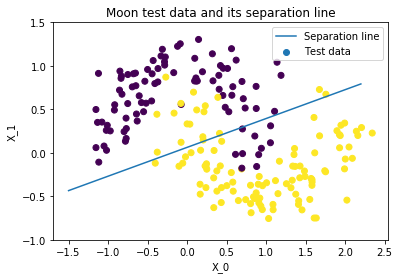

In [9]:
visualizeLine()

Now we want to evaluate our model using the test data.

In [10]:
def predict(X, w_opt, threshold=0.5):
    """
        Arguments:
            X (array) : input
            w_opt (array) : optimal parameter of the model
            threshold (float) : separation to choose between class one and two
            
        Returns: 
            y_pred (int) : 0 or 1
    """
    y_float_pred = sigmoid(np.matmul(w_opt[0:2], X.T) + w_opt[2])
    y_pred = [1 if val >= threshold else 0 for val in y_float_pred]
    return y_pred

In [11]:
def evaluateModel(y_pred_test):
    """
        Argument :
            y_pred_test (array) : labels predited on the test set
    """
    acc = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
    auc = roc_auc_score(y_true=y_test, y_score=y_pred_test)
    print("Accuracy =", acc, "\n conf_mat =", conf_mat, "\n auc = ", auc)

In [12]:
y_pred_test = predict(X=X_test, w_opt=omega_opt)
evaluateModel(y_pred_test=y_pred_test)

Accuracy = 0.86 
 conf_mat = [[81 10]
 [18 91]] 
 auc =  0.8624861377154954


### Metropolis Hasting Sampling of the posterior

Now we wish to extract sample for the posterior distribution. In order to acheive this we are going to use a MCMC method.

$p(y | X, \omega) \equiv \displaystyle \prod_{i=1}^N \sigma(\omega^T \tilde{X_i})^{y_i} (1-\sigma(\omega^T \tilde{X_i}))^{1-y_i} \times \dfrac{1}{\sqrt{(2\pi)^3|\Sigma|}} \exp{(-\dfrac{1}{2}\displaystyle\sum_{i=0}^2 \dfrac{(\omega_i-\mu_i)^2}{\sigma_i^2})} $

In [13]:
def posterior(omega, X, y, mu_prior=mu_prior, beta_prior=beta_prior):
    """
        Calculate the posterior. We have posterior(args) = np.exp(-nll(args)).
        Have the exact same argument as nll function.
    """
    n_samples_X = X.shape[0]
    
    # generative part
    posterior = 1
    for i in range(0, n_samples_X):
        # w0*X0 + w1*X1 + w2
        sigmoid_value = sigmoid(np.matmul(omega[:2], X[i,:].T) + omega[2])
        if y[i] == 0:
            posterior *= (1-sigmoid_value)
        else:
            posterior *= sigmoid_value
        
    # prior part
    prior_part = np.exp(-(1/(2*beta_prior**2))*np.sum((omega-mu_prior)**2))
    
    # nll total 
    posterior *= prior_part
    return posterior

In [14]:
class ProposalDensity:
    
    def __init__(self, name, variance=1):
        """
            Initialize a ProposalDensity object.
            
            Arguments:
                name (str) : can either be "normal" or "uniform". 
                    They represent multivariate distribution in R^3.
                variance (int) : variance of the different distributions.
        """
        self.name = name
        self.scale_uniform = variance*2
        self.cov_normal = variance*np.identity(3)
        
        
    def density_valuation(self, w_new, w_before):
        
        if self.name == "normal":
            return multivariate_normal.pdf(x=w_new, mean=w_before, cov=self.cov_normal)
        
        elif self.name == "uniform":
            # uniform distribution thus the probability is the same.
            # for dimension d => proba = 1/scale**d
            return 1/self.scale_uniform**3
        
        
    def sample(self, w_before):
        
        if self.name == "normal":
            return multivariate_normal.rvs(mean=w_before, cov=self.cov_normal, size=1)
        
        elif self.name == "uniform":
            return np.array([uniform.rvs(loc=w_before[i]-self.scale_uniform/2, scale=self.scale_uniform) for i in range(3)])

In [15]:
def metropolis_hastings_sample(proposal_name, n_generate_sample, w0, max_iter_possible=10**(9)):
    """
        Compute the Metropolis Hastings algorithm. Look for good samples to keep to describe the
        posterior distribution at the end.
    
        Arguments:
            proposal_name (string) : "normal" or "uniform" see the Proposal class for more details.
            n_generate_sample (int) : number of samples you wish to compute
            w0 (array) : initial input sample
            max_iter_possible (int) : much bigger than m_generate_sample. Just to make sure the algorithm does not
                run forever.
        
        Returns:
            stock_sample (array) : shape (n_generate_sample, len(w0)) contains all the accpeted samples.
    """
    epsilon = 10**(-250) # just to make sure to not have any log(0) problem
    proposal = ProposalDensity(name=proposal_name)
    nb_samples = 0
    stock_sample = np.zeros(shape=(n_generate_sample, len(w0)))
    w_c = w0
    max_iter = 0
    while nb_samples < n_generate_sample and max_iter < max_iter_possible:
        
        # new sample proposition
        w_t = proposal.sample(w_before=w_c)
        
        # acceptance probability computation (first compute r1-r2=log(r) then r=exp(r1-r2))
        r1 = np.log(posterior(omega=w_t, 
                              X=X_train, 
                              y=y_train, 
                              mu_prior=mu_prior, 
                              beta_prior=beta_prior)+epsilon) + \
             np.log(proposal.density_valuation(w_new=w_c, w_before=w_t)+epsilon)
        
        r2 = np.log(posterior(omega=w_c, 
                              X=X_train, 
                              y=y_train, 
                              mu_prior=mu_prior, 
                              beta_prior=beta_prior)+epsilon) + \
             np.log(proposal.density_valuation(w_new=w_t, w_before=w_c)+epsilon)
        
        r = np.exp(r1 - r2)
        
        # generate a uniform sample in [0, 1]
        u = uniform.rvs(size=1, loc=0, scale=1)[0]
        
        # accept or refuse the sample
        if u < r:
            w_c = w_t
            stock_sample[nb_samples] = w_c
            nb_samples += 1
        max_iter += 1
    
    if max_iter == max_iter_possible:
        print("Algorithm stopped earlier because the number of iterations was to big.")
    
    return stock_sample

In [16]:
# take the optimal found before as initial sample and get samples
mh_samples = metropolis_hastings_sample(proposal_name="normal", n_generate_sample=50, w0=omega_opt)

#### Histograms of parameters

After creating the samples, we can get the histograms of every parameters.

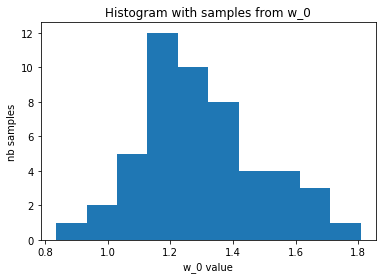

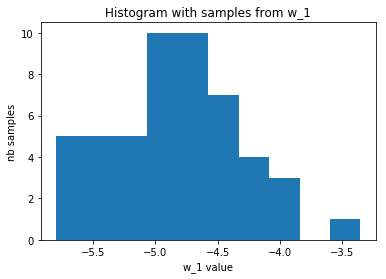

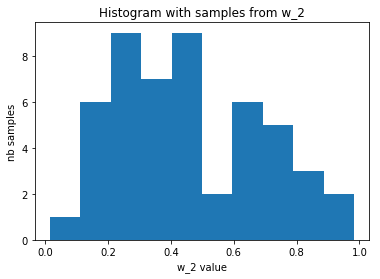

In [17]:
for i in range(3):
    plt.hist(mh_samples[:, i]) #, range=(-10, 10))
    plt.title("Histogram with samples from w_"+str(i))
    plt.xlabel("w_"+str(i)+" value")
    plt.ylabel("nb samples")
    plt.show()

#### Visualize lines from sampled parameters

We now would like to visualize some of the lines from the samples and see if it makes sense.

index = 4
index = 22
index = 35
index = 40
index = 7


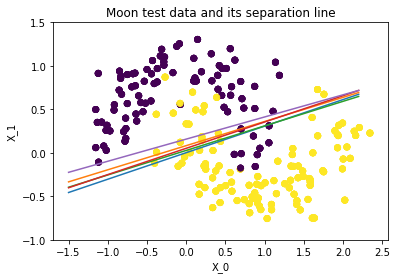

In [18]:
nb_lines_to_visualize = 5
for _ in range(nb_lines_to_visualize):
    index_sample = np.random.randint(len(mh_samples))
    # print("Sample index =", index_sample)
    visualizeLine(omega=mh_samples[index_sample, :], legend=False, display_omega=False)

omega optimal used : [ 1.2961956  -4.80625544  0.46140713]


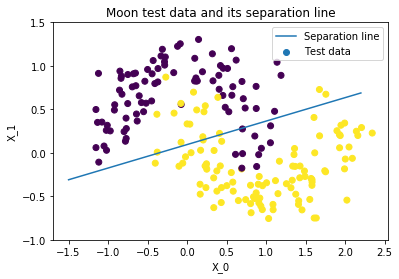

In [19]:
# get the mean value for omega from MH
omega_mean_mh = np.mean(mh_samples, axis=0) # not good ~
visualizeLine(omega=omega_mean_mh)

### Monte Carlos Integral for predictions

We have that :

$p(y_* | x_*, X, Y) = \int p(y_* | x_*, \omega)p(\omega| X, Y)d\omega = E_{\omega| X, Y}[p(y_* | x_*, \omega)] \simeq \dfrac{1}{n}\displaystyle\sum_{i=1}^{n} p(y_* | x_*, \omega) = \dfrac{1}{n}\displaystyle\sum_{i=1}^{n} \sigma(\omega_i^T \tilde{x_*})$

Where the elements $\omega_i$ are generated from the posterior distribution $p(\omega| X, Y)$.

In [20]:
def monte_carlos_prediction(w_samples, X, thinning_step=1, burnin=0, threshold=0.5):
    """
        Arguments:
            w_samples (array) : shape (n_samples, 3)
            X (array) : get prediction out of this array
            thinning_step (float) : step to extract samples for calculating the integral
                with a smaller autocorrelation between parameters
            burnin (float) : number of fisrt values to NOT consider in w_samples
            
        Returns:
            y_pred (array) : prediction for each element in X_to_predict
    """
    n_pred = X.shape[0]
    w_samples_used = np.array([param for i, param in enumerate(w_samples[burnin:]) if i%thinning_step == 0])
    y_pred = np.zeros(n_pred)
    for i in range(n_pred):
        y_pred[i] = np.mean(sigmoid(np.matmul(w_samples_used[:, :2], X[i, :].T) + w_samples_used[:, 2]))
    y_pred = np.array([1 if val >= threshold else 0 for val in y_pred])
    return y_pred

In [21]:
y_pred = monte_carlos_prediction(w_samples=mh_samples, X=X_test)
evaluateModel(y_pred_test=y_pred)

Accuracy = 0.865 
 conf_mat = [[81 10]
 [17 92]] 
 auc =  0.8670732936787983
